# Project Title
### Data Engineering Capstone Project

### Project Summary

This project is primarily scoped to illustrate the fitness of modern “Data Engineering Technologies”, such as Spark, Apache Airflow, Redshift, S3 and Cloud infrastructure, in solutioning of large-scale data transformation (Big data ETL, Data lake) which can scale and adapt to growing needs of business and data scientist.

Although evaluation and fitment of technology is primary driver, data quality and data size are important factor for success of this project. We will use data set provided by Udacity. Udacity data set is free for its students, good quality and high volume.





In [1]:
from pyspark.sql import SparkSession, SQLContext, GroupedData, HiveContext
from pyspark.sql.functions import *
from pyspark.sql.functions import date_add as d_add
from pyspark.sql.types import DoubleType
from pyspark.sql.functions import year, month, dayofmonth, weekofyear, date_format
from pyspark.sql import functions as F
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.sql.functions import lit
from pyspark.sql import Row

### Step 1: Scope the Project and Gather Data

#### Business use case

Project will focus to answer below insights/query and will guide design of LDM (Logical data model) of OLAP (Fact – Dimension model). 

    •	Insight on visitor type (Student, Tourism, Skilled worker, Business)
    •	Country of visitor
    •	Destination of visitor (US cities)
    •	Climate/temperature of US cities 
    
#### Datasets
We will use data set provided by Udacity. Udacity data set is free for its students, good quality and high volume.

    •	I94 Immigration Data: This data comes from the US National Tourism and Trade Office. This is where the data comes from. 
    •	World Temperature Data: This dataset came from Kaggle. You can read more about it here.
    •	U.S. City Demographic Data: This data comes from OpenSoft. You can read more about it here.
    •	Airport Code Table: This is a simple table of airport codes and corresponding cities. It comes from here.




### Common Function


In [2]:
##Reference: https://stackoverflow.com/questions/39758045/how-to-perform-union-on-two-dataframes-with-different-amounts-of-columns-in-spar

output_path = "output_data/"
def write_to_parquet(table, file_name):
    """
    Write the table as parquet file
    
    Parameters:
        table
        Name of the file
    Returns:
        Outputs the table as parquet file to a folder
    """
    file_output = output_path + file_name
    table.write.mode("overwrite").parquet(file_output)
    
def customUnion(df1, df2):
    """
    Combines two dataframes 
    
    Parameters:
         dataframe1
         dataframe2
     
     Returns:
         A combined dataframe
    """
    cols1 = df1.columns
    cols2 = df2.columns
    total_cols = sorted(cols1 + list(set(cols2) - set(cols1)))
    def expr(mycols, allcols):
        def processCols(colname):
            if colname in mycols:
                return colname
            else:
                return lit(None).alias(colname)
        cols = map(processCols, allcols)
        return list(cols)
    appended = df1.select(expr(cols1, total_cols)).union(df2.select(expr(cols2, total_cols)))
    return appended

### Import Immigration Data

In [3]:
folder = 'sas_data'
spark = SparkSession.builder.\
config("spark.jars.packages","saurfang:spark-sas7bdat:2.0.0-s_2.11")\
.config("spark.python.worker.memory", "15g") \
.enableHiveSupport().getOrCreate()
df=spark.read.parquet(folder)

#### Data Dictionary
* cicid - float64 - ID that uniquely identify one record in the dataset
* i94yr - float64 - 4 digit year
* i94mon- float64 - Numeric month
* i94cit - float64 - 3 digit code of source city for immigration (Born country)
* i94res - float64 - 3 digit code of source country for immigration (Residence country)
* i94port - object - Port addmitted through
* arrdate - float64 - Arrival date in the USA
* i94mode - float64 - Mode of transportation (1 = Air; 2 = Sea; 3 = Land; 9 = Not reported)
* i94addr - object - State of arrival
* depdate  -float64 - Departure date
* i94bir - float64 - Age of Respondent in Years
* i94visa - float64 - Visa codes collapsed into three categories: (1 = Business; 2 = Pleasure; 3 = Student)
* count - float64 - Used for summary statistics
* dtadfile - object - Character Date Field
* visapost - object - Department of State where where Visa was issued
* occup - object - Occupation that will be performed in U.S.
* entdepa - object - Arrival Flag. Whether admitted or paroled into the US
* entdepd - object - Departure Flag. Whether departed, lost visa, or deceased
* entdepu - object - Update Flag. Update of visa, either apprehended, overstayed, or updated to PR
* matflag - object - Match flag
* biryear - float64 - 4 digit year of birth
* dtaddto - object - Character date field to when admitted in the US
* gender  - object - Gender
* insnum  -  object - INS number
* airline -    object - Airline used to arrive in U.S.
* admnum -     float64 - Admission number, should be unique and not nullable
* fltno   -     object - Flight number of Airline used to arrive in U.S.
* visatype  -  object - Class of admission legally admitting the non-immigrant to temporarily stay in U.S.

### Step 2: Explore and Assess the Data


In [4]:
df.printSchema()


root
 |-- cicid: double (nullable = true)
 |-- i94yr: double (nullable = true)
 |-- i94mon: double (nullable = true)
 |-- i94cit: double (nullable = true)
 |-- i94res: double (nullable = true)
 |-- i94port: string (nullable = true)
 |-- arrdate: double (nullable = true)
 |-- i94mode: double (nullable = true)
 |-- i94addr: string (nullable = true)
 |-- depdate: double (nullable = true)
 |-- i94bir: double (nullable = true)
 |-- i94visa: double (nullable = true)
 |-- count: double (nullable = true)
 |-- dtadfile: string (nullable = true)
 |-- visapost: string (nullable = true)
 |-- occup: string (nullable = true)
 |-- entdepa: string (nullable = true)
 |-- entdepd: string (nullable = true)
 |-- entdepu: string (nullable = true)
 |-- matflag: string (nullable = true)
 |-- biryear: double (nullable = true)
 |-- dtaddto: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- insnum: string (nullable = true)
 |-- airline: string (nullable = true)
 |-- admnum: double (nullable = 

### Adjust data types

In [5]:
df = df \
.withColumn("cicid", col("cicid").cast("integer")) \
.withColumn("year", col("i94yr").cast("integer")) \
.drop("i94yr") \
.withColumn("month", col("i94mon").cast("integer")) \
.drop("i94mon") \
.withColumn("bornCountry", col("i94cit").cast("integer")) \
.drop("i94cit") \
.withColumn("residentCountry", col("i94res").cast("integer")) \
.drop("i94res") \
.withColumnRenamed("i94port", "arrivalPort") \
.withColumn("mode", col("i94mode").cast("integer")) \
.drop("i94mode") \
.withColumnRenamed("i94addr", "arrivalAddress") \
.withColumn("age", col("i94bir").cast("integer")) \
.drop("i94bir") \
.withColumn("visa", col("i94visa").cast("integer")) \
.drop("i94visa") \
.withColumnRenamed("entdepa", "arrivalFlag") \
.withColumnRenamed("entdepd", "departureFlag") \
.withColumnRenamed("entdepu", "updateFlag") \
.withColumnRenamed("matflag", "matchFlag") \
.withColumn("birthYear", col("biryear").cast("integer")) \
.drop("biryear") \
.withColumnRenamed("fltno", "flightNumber") \
.withColumnRenamed("visaType", "visaType") \
.withColumn("sasDate", to_date(lit("01/01/1960"), "MM/dd/yyyy")) \
.withColumn("arrivalDate", expr("date_add(sasDate, arrdate)")) \
.withColumn("departureDate", expr("date_add(sasDate, depdate)")) \
.drop("sasDate", "arrdate", "depdate", "count", "admnum", "dtadfile", "visapost", "occup", "dtaddto", "insnum")

In [6]:
df.printSchema()

root
 |-- cicid: integer (nullable = true)
 |-- arrivalPort: string (nullable = true)
 |-- arrivalAddress: string (nullable = true)
 |-- arrivalFlag: string (nullable = true)
 |-- departureFlag: string (nullable = true)
 |-- updateFlag: string (nullable = true)
 |-- matchFlag: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- airline: string (nullable = true)
 |-- flightNumber: string (nullable = true)
 |-- visaType: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- bornCountry: integer (nullable = true)
 |-- residentCountry: integer (nullable = true)
 |-- mode: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- visa: integer (nullable = true)
 |-- birthYear: integer (nullable = true)
 |-- arrivalDate: date (nullable = true)
 |-- departureDate: date (nullable = true)



### drop duplicates

In [7]:
df = df.where((col("age") >= 0) & (col("cicid").isNotNull())) \
     .dropDuplicates(['cicid'])

In [8]:
df.show(2)

+-----+-----------+--------------+-----------+-------------+----------+---------+------+-------+------------+--------+----+-----+-----------+---------------+----+---+----+---------+-----------+-------------+
|cicid|arrivalPort|arrivalAddress|arrivalFlag|departureFlag|updateFlag|matchFlag|gender|airline|flightNumber|visaType|year|month|bornCountry|residentCountry|mode|age|visa|birthYear|arrivalDate|departureDate|
+-----+-----------+--------------+-----------+-------------+----------+---------+------+-------+------------+--------+----+-----+-----------+---------------+----+---+----+---------+-----------+-------------+
|  148|        NEW|            NY|          G|            O|      null|        M|     F|     OS|       00089|      WT|2016|    4|        103|            103|   1| 21|   2|     1995| 2016-04-01|   2016-04-08|
|  463|        MIA|            FL|          O|            R|      null|        M|  null|     OS|       00097|      WT|2016|    4|        103|            103|   1| 25|  

In [9]:
print((df.count(), len(df.columns)))

(3095510, 21)


### Dimensions table

In [10]:
time_table = df.select(['arrivalDate'])\
                    .withColumnRenamed('arrivalDate','time') 

time_table = time_table \
             .withColumn('day', F.dayofmonth('time')) \
             .withColumn('month', F.month('time')) \
             .withColumn('year', F.year('time')) \
             .withColumn('week', F.weekofyear('time')) \
             .withColumn('weekday', F.dayofweek('time'))\
             .dropDuplicates()
write_to_parquet(time_table,"time_table.parquet" )

In [11]:
time_table.show(2)

+----------+---+-----+----+----+-------+
|      time|day|month|year|week|weekday|
+----------+---+-----+----+----+-------+
|2016-04-01|  1|    4|2016|  13|      6|
|2016-04-06|  6|    4|2016|  14|      4|
+----------+---+-----+----+----+-------+
only showing top 2 rows



In [12]:
print("Time data schema:")
time_table.printSchema()

Time data schema:
root
 |-- time: date (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- week: integer (nullable = true)
 |-- weekday: integer (nullable = true)



In [13]:

print((time_table.count(), len(time_table.columns)))

(30, 6)


In [14]:
person_table = df.select(['birthYear','gender']) \
                 .dropDuplicates() \
                 .withColumn("personId", \
                        monotonically_increasing_id())
print((person_table.count(), len(person_table.columns)))

(475, 3)


In [15]:
print("Person data schema:")
write_to_parquet(person_table,"person_table.parquet" )
person_table.printSchema()

Person data schema:
root
 |-- birthYear: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- personId: long (nullable = false)



In [16]:
person_table.show(2)

+---------+------+--------+
|birthYear|gender|personId|
+---------+------+--------+
|     1959|  null|       0|
|     2004|     F|       1|
+---------+------+--------+
only showing top 2 rows



In [17]:
country_table = df.select('bornCountry').distinct().withColumnRenamed("bornCountry", "country") \
                  .withColumn("countryId", \
                        monotonically_increasing_id())
                 
print((country_table.count(), len(country_table.columns)))

(243, 2)


In [18]:
write_to_parquet(country_table,"country_table.parquet" )

In [19]:
print("Country data schema:")
country_table.printSchema()

Country data schema:
root
 |-- country: integer (nullable = true)
 |-- countryId: long (nullable = false)



In [20]:
country_table.show(2)

+-------+----------+
|country| countryId|
+-------+----------+
|    148|         0|
|    392|8589934592|
+-------+----------+
only showing top 2 rows



### Arrival

In [21]:
arrival_port_table = df.groupby('arrivalPort') \
                     .agg(F.countDistinct("arrivalAddress")).withColumnRenamed("count(DISTINCT arrivalAddress)","numArrivalAddress") \
                     .dropna() \
                     .dropDuplicates()\
                     .withColumn("arrivalPortId", \
                        monotonically_increasing_id())
print((arrival_port_table.count(), len(arrival_port_table.columns)))

(299, 3)


In [22]:
write_to_parquet(arrival_port_table,"arrival_port_table.parquet" )

In [23]:
arrival_port_table.show(2)

+-----------+-----------------+-------------+
|arrivalPort|numArrivalAddress|arrivalPortId|
+-----------+-----------------+-------------+
|        FMY|               74|            0|
|        BGM|               15|            1|
+-----------+-----------------+-------------+
only showing top 2 rows



In [24]:
print("Arrival Port data schema:")
arrival_port_table.printSchema()

Arrival Port data schema:
root
 |-- arrivalPort: string (nullable = true)
 |-- numArrivalAddress: long (nullable = false)
 |-- arrivalPortId: long (nullable = false)



#### Status

In [25]:
status_table = df.select(['arrivalFlag','departureFlag', 'updateFlag','matchFlag']) \
                 .dropna() \
               .dropDuplicates() \
               .withColumn("statusFlagId", \
                        monotonically_increasing_id()) 
print((status_table.count(), len(status_table.columns)))

(16, 5)


In [26]:
write_to_parquet(status_table,"status_table.parquet" )

In [27]:
print("Status Flag data schema:")
status_table.printSchema()

Status Flag data schema:
root
 |-- arrivalFlag: string (nullable = true)
 |-- departureFlag: string (nullable = true)
 |-- updateFlag: string (nullable = true)
 |-- matchFlag: string (nullable = true)
 |-- statusFlagId: long (nullable = false)



### Airport Code Table

### Data Dictionary

* ident -Unique identifier
* type - Type of the airport
* name - Airport Name
* elevation_ft - Altitude of the airport
* continent - Continent
* iso_country -ISO code of the country of the airport
* iso_region - ISO code for the region of the airport
* municipality - City where the airport is located
* gps_code - GPS code of the airport
* iata_code - IATA code of the airport
* local_code - Local code of the airport
* coordinates - GPS coordinates of the airport

In [28]:
airport = spark.read.format("csv").option("header", "true").option("delimiter", ",").load("airport-codes_csv.csv")

In [29]:
airport.show(2)

+-----+-------------+--------------------+------------+---------+-----------+----------+------------+--------+---------+----------+--------------------+
|ident|         type|                name|elevation_ft|continent|iso_country|iso_region|municipality|gps_code|iata_code|local_code|         coordinates|
+-----+-------------+--------------------+------------+---------+-----------+----------+------------+--------+---------+----------+--------------------+
|  00A|     heliport|   Total Rf Heliport|          11|       NA|         US|     US-PA|    Bensalem|     00A|     null|       00A|-74.9336013793945...|
| 00AA|small_airport|Aero B Ranch Airport|        3435|       NA|         US|     US-KS|       Leoti|    00AA|     null|      00AA|-101.473911, 38.7...|
+-----+-------------+--------------------+------------+---------+-----------+----------+------------+--------+---------+----------+--------------------+
only showing top 2 rows



#### Select only US, where iata_code is available and valid airport

In [30]:
airport =   airport \
            .where(
            (col("iso_country") == "US") & (col("iata_code").isNotNull()) & (col("type").isin("large_airport", "medium_airport", "small_airport"))) \
            .withColumn("isoRegion", substring(col("iso_region"), 4, 2)) \
            .drop("local_code", "elevation_ft", "iso_region", 'continent') \
            .dropDuplicates()

In [31]:
print("Airport data schema:")
airport.printSchema()

Airport data schema:
root
 |-- ident: string (nullable = true)
 |-- type: string (nullable = true)
 |-- name: string (nullable = true)
 |-- iso_country: string (nullable = true)
 |-- municipality: string (nullable = true)
 |-- gps_code: string (nullable = true)
 |-- iata_code: string (nullable = true)
 |-- coordinates: string (nullable = true)
 |-- isoRegion: string (nullable = true)



In [32]:
airport_table = airport.select(['ident', 'type', 'name', 'isoRegion', 'municipality','gps_code', 'iata_code','iso_country', 'coordinates']) \
               .dropDuplicates().dropna()
write_to_parquet(airport_table,"airport_table.parquet" )

In [33]:
print("Airport data schema:")
airport_table.printSchema()

Airport data schema:
root
 |-- ident: string (nullable = true)
 |-- type: string (nullable = true)
 |-- name: string (nullable = true)
 |-- isoRegion: string (nullable = true)
 |-- municipality: string (nullable = true)
 |-- gps_code: string (nullable = true)
 |-- iata_code: string (nullable = true)
 |-- iso_country: string (nullable = true)
 |-- coordinates: string (nullable = true)



### World Temperature Data: 

In [34]:
temperature_file_name = '../../data2/GlobalLandTemperaturesByCity.csv'
temperature = spark.read.format("csv").option("header", "true").option("delimiter", ",").load(temperature_file_name)

In [35]:
temperature.show(2)

+----------+------------------+-----------------------------+-----+-------+--------+---------+
|        dt|AverageTemperature|AverageTemperatureUncertainty| City|Country|Latitude|Longitude|
+----------+------------------+-----------------------------+-----+-------+--------+---------+
|1743-11-01|             6.068|           1.7369999999999999|Århus|Denmark|  57.05N|   10.33E|
|1743-12-01|              null|                         null|Århus|Denmark|  57.05N|   10.33E|
+----------+------------------+-----------------------------+-----+-------+--------+---------+
only showing top 2 rows



In [36]:
print("GlobalLandTemperatures data schema:")
temperature.printSchema()

GlobalLandTemperatures data schema:
root
 |-- dt: string (nullable = true)
 |-- AverageTemperature: string (nullable = true)
 |-- AverageTemperatureUncertainty: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Latitude: string (nullable = true)
 |-- Longitude: string (nullable = true)



### U.S. City Demographic Data

In [37]:
dem = spark.read.format("csv").option("header", "true").option("delimiter", ";").load("us-cities-demographics.csv")

In [38]:
print("Demographics data schema:")
dem.printSchema()

Demographics data schema:
root
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Median Age: string (nullable = true)
 |-- Male Population: string (nullable = true)
 |-- Female Population: string (nullable = true)
 |-- Total Population: string (nullable = true)
 |-- Number of Veterans: string (nullable = true)
 |-- Foreign-born: string (nullable = true)
 |-- Average Household Size: string (nullable = true)
 |-- State Code: string (nullable = true)
 |-- Race: string (nullable = true)
 |-- Count: string (nullable = true)



### Groupby and aggregrate columns

In [39]:
dem_table = dem \
.groupBy(col("State Code").alias("stateCode"), col("State").alias("state")).agg(
round(mean('Median Age'), 2).alias("medianAge"),\
sum("Total Population").alias("totalPopulation"),\
sum("Male Population").alias("malePopulation"), \
sum("Female Population").alias("femalePopulation"),\
sum("Number of Veterans").alias("numberOfVeterans"),\
sum("Foreign-born").alias("foreignBorn"), \
round(mean("Average Household Size"),2).alias("averageHouseholdSize")
).dropna()

In [40]:
dem_table.show(2)

+---------+--------------+---------+---------------+--------------+----------------+----------------+-----------+--------------------+
|stateCode|         state|medianAge|totalPopulation|malePopulation|femalePopulation|numberOfVeterans|foreignBorn|averageHouseholdSize|
+---------+--------------+---------+---------------+--------------+----------------+----------------+-----------+--------------------+
|       MT|       Montana|     35.5|       906470.0|      438535.0|        467935.0|         69270.0|    29885.0|                2.27|
|       NC|North Carolina|    33.79|    1.5300995E7|     7330525.0|       7970470.0|        830730.0|  1896635.0|                2.48|
+---------+--------------+---------+---------------+--------------+----------------+----------------+-----------+--------------------+
only showing top 2 rows



In [41]:
print("New Demographics data schema:")
dem_table.printSchema()

New Demographics data schema:
root
 |-- stateCode: string (nullable = true)
 |-- state: string (nullable = true)
 |-- medianAge: double (nullable = true)
 |-- totalPopulation: double (nullable = true)
 |-- malePopulation: double (nullable = true)
 |-- femalePopulation: double (nullable = true)
 |-- numberOfVeterans: double (nullable = true)
 |-- foreignBorn: double (nullable = true)
 |-- averageHouseholdSize: double (nullable = true)



In [42]:
write_to_parquet(dem_table,"dem_table.parquet" )

In [43]:
small_table = df.select(['cicid', 'arrivalDate','departureDate','mode','bornCountry', 'airline','flightNumber','visa','visaType',
                         'gender','arrivalPort', 'matchFlag']) \
                .dropna() \
                .dropDuplicates(['cicid'])
small_table = small_table.withColumnRenamed("arrivalDate", "time")   

In [44]:
small_table = small_table.withColumn('stateCode', F.array( F.lit("MT"), F.lit("NY"),F.lit("SC"),).getItem(
    (F.rand()*3).cast("int"))) \
                     .withColumn("ident", F.array( F.lit("KBOI"), F.lit("KVEE"),F.lit("STOB"),).getItem(
    (F.rand()*3).cast("int"))) \
                .dropDuplicates()
small_table.show()

+-----+----------+-------------+----+-----------+-------+------------+----+--------+------+-----------+---------+---------+-----+
|cicid|      time|departureDate|mode|bornCountry|airline|flightNumber|visa|visaType|gender|arrivalPort|matchFlag|stateCode|ident|
+-----+----------+-------------+----+-----------+-------+------------+----+--------+------+-----------+---------+---------+-----+
|  148|2016-04-01|   2016-04-08|   1|        103|     OS|       00089|   2|      WT|     F|        NEW|        M|       SC| KBOI|
|  471|2016-04-01|   2016-04-03|   2|        103|    VES|       91285|   2|      WT|     M|        MIA|        M|       NY| KBOI|
|  833|2016-04-01|   2016-04-09|   1|        104|     FI|       00631|   2|      WT|     F|        BOS|        M|       NY| KVEE|
| 1088|2016-04-01|   2016-04-08|   1|        104|     DL|       00149|   2|      WT|     F|        NEW|        M|       SC| KBOI|
| 1238|2016-04-01|   2016-04-09|   1|        104|     AF|       00006|   2|      WT|     M

In [45]:
print((small_table.count(), len(small_table.columns))) 

(2482042, 14)


In [46]:
small_table = small_table.join(status_table.select(['statusFlagId', 'matchFlag']), (small_table.matchFlag == status_table.matchFlag) , how = 'inner') \
                       .drop('matchFlag') \
                       .dropna() \
                       .dropDuplicates() 
small_table.show()

+-----+----------+-------------+----+-----------+-------+------------+----+--------+------+-----------+---------+-----+-------------+
|cicid|      time|departureDate|mode|bornCountry|airline|flightNumber|visa|visaType|gender|arrivalPort|stateCode|ident| statusFlagId|
+-----+----------+-------------+----+-----------+-------+------------+----+--------+------+-----------+---------+-----+-------------+
|  148|2016-04-01|   2016-04-08|   1|        103|     OS|       00089|   2|      WT|     F|        NEW|       SC| KBOI|1675037245440|
|  148|2016-04-01|   2016-04-08|   1|        103|     OS|       00089|   2|      WT|     F|        NEW|       SC| KBOI|1640677507072|
|  148|2016-04-01|   2016-04-08|   1|        103|     OS|       00089|   2|      WT|     F|        NEW|       SC| KBOI|1632087572480|
|  148|2016-04-01|   2016-04-08|   1|        103|     OS|       00089|   2|      WT|     F|        NEW|       SC| KBOI|1623497637888|
|  148|2016-04-01|   2016-04-08|   1|        103|     OS|     

In [47]:
print((small_table.count(), len(small_table.columns)))

(39712672, 14)


In [48]:
small_table = small_table.join(arrival_port_table.select(['arrivalPortId', 'arrivalPort']), (small_table.arrivalPort == arrival_port_table.arrivalPort) , how = 'inner') \
                       .drop('arrivalPort') \
                       .dropna() \
                       .dropDuplicates()
small_table.show(2)

+-----+----------+-------------+----+-----------+-------+------------+----+--------+------+---------+-----+-------------+-------------+
|cicid|      time|departureDate|mode|bornCountry|airline|flightNumber|visa|visaType|gender|stateCode|ident| statusFlagId|arrivalPortId|
+-----+----------+-------------+----+-----------+-------+------------+----+--------+------+---------+-----+-------------+-------------+
|  148|2016-04-01|   2016-04-08|   1|        103|     OS|       00089|   2|      WT|     F|       SC| KBOI|1675037245440| 747324309504|
|  148|2016-04-01|   2016-04-08|   1|        103|     OS|       00089|   2|      WT|     F|       SC| KBOI|1640677507072| 747324309504|
+-----+----------+-------------+----+-----------+-------+------------+----+--------+------+---------+-----+-------------+-------------+
only showing top 2 rows



In [49]:
small_table = small_table.join(country_table, (small_table.bornCountry == country_table.country) , how = 'inner') \
                         .dropna() \
                        .drop('bornCountry', 'country') \
                       .dropDuplicates()
small_table.show(2)

+-----+----------+-------------+----+-------+------------+----+--------+------+---------+-----+-------------+-------------+------------+
|cicid|      time|departureDate|mode|airline|flightNumber|visa|visaType|gender|stateCode|ident| statusFlagId|arrivalPortId|   countryId|
+-----+----------+-------------+----+-------+------------+----+--------+------+---------+-----+-------------+-------------+------------+
|  148|2016-04-01|   2016-04-08|   1|     OS|       00089|   2|      WT|     F|       SC| KBOI|1675037245440| 747324309504|197568495616|
|  148|2016-04-01|   2016-04-08|   1|     OS|       00089|   2|      WT|     F|       SC| KBOI|1640677507072| 747324309504|197568495616|
+-----+----------+-------------+----+-------+------------+----+--------+------+---------+-----+-------------+-------------+------------+
only showing top 2 rows



In [50]:
i94_table = small_table.join(person_table.select(['personId', 'gender']), (small_table.gender == person_table.gender) , how = 'inner') \
                      .drop('gender') \
                      .dropna() \
                      .dropDuplicates()

In [51]:
print("Fact Table schema:")
i94_table.printSchema()

Fact Table schema:
root
 |-- cicid: integer (nullable = true)
 |-- time: date (nullable = true)
 |-- departureDate: date (nullable = true)
 |-- mode: integer (nullable = true)
 |-- airline: string (nullable = true)
 |-- flightNumber: string (nullable = true)
 |-- visa: integer (nullable = true)
 |-- visaType: string (nullable = true)
 |-- stateCode: string (nullable = true)
 |-- ident: string (nullable = true)
 |-- statusFlagId: long (nullable = false)
 |-- arrivalPortId: long (nullable = false)
 |-- countryId: long (nullable = false)
 |-- personId: long (nullable = false)



In [52]:
i94_table.show()

+-----+----------+-------------+----+-------+------------+----+--------+---------+-----+-------------+-------------+-------------+-----------+
|cicid|      time|departureDate|mode|airline|flightNumber|visa|visaType|stateCode|ident| statusFlagId|arrivalPortId|    countryId|   personId|
+-----+----------+-------------+----+-------+------------+----+--------+---------+-----+-------------+-------------+-------------+-----------+
|69637|2016-04-01|   2016-04-02|   1|     MU|       00577|   2|      B2|       SC| KVEE| 120259084288|            0|1133871366144|          1|
|69637|2016-04-01|   2016-04-02|   1|     MU|       00577|   2|      B2|       SC| KVEE| 146028888064|            0|1133871366144|          1|
|69637|2016-04-01|   2016-04-02|   1|     MU|       00577|   2|      B2|       SC| KVEE| 214748364800|            0|1133871366144|          1|
|69637|2016-04-01|   2016-04-02|   1|     MU|       00577|   2|      B2|       SC| KVEE| 523986010112|            0|1133871366144|          1|

In [53]:
i94_table =i94_table \
        .withColumn("arrival_date-split", split(col("time"), "-")) \
        .withColumn("arrivalDay", col("arrival_date-split")[2]) \
        .drop("arrival_date-split")

In [54]:
i94_table.printSchema()

root
 |-- cicid: integer (nullable = true)
 |-- time: date (nullable = true)
 |-- departureDate: date (nullable = true)
 |-- mode: integer (nullable = true)
 |-- airline: string (nullable = true)
 |-- flightNumber: string (nullable = true)
 |-- visa: integer (nullable = true)
 |-- visaType: string (nullable = true)
 |-- stateCode: string (nullable = true)
 |-- ident: string (nullable = true)
 |-- statusFlagId: long (nullable = false)
 |-- arrivalPortId: long (nullable = false)
 |-- countryId: long (nullable = false)
 |-- personId: long (nullable = false)
 |-- arrivalDay: string (nullable = true)



## Partition by day

In [55]:
i94_table =i94_table \
        .withColumn("arrival_date-split", split(col("time"), "-")) \
        .withColumn("arrivalDay", col("arrival_date-split")[2]) \
        .drop("arrival_date-split")

In [56]:
i94_table.printSchema()

root
 |-- cicid: integer (nullable = true)
 |-- time: date (nullable = true)
 |-- departureDate: date (nullable = true)
 |-- mode: integer (nullable = true)
 |-- airline: string (nullable = true)
 |-- flightNumber: string (nullable = true)
 |-- visa: integer (nullable = true)
 |-- visaType: string (nullable = true)
 |-- stateCode: string (nullable = true)
 |-- ident: string (nullable = true)
 |-- statusFlagId: long (nullable = false)
 |-- arrivalPortId: long (nullable = false)
 |-- countryId: long (nullable = false)
 |-- personId: long (nullable = false)
 |-- arrivalDay: string (nullable = true)



### Step 3: Define the Data Model

### Solution Building blocks 

#### AWS
    This project will use EC2, S3, EMR cluster (Spark), Apache Airflow - will be core components of solution design.
    a)	S3 – Storage 
    b)	EMR – Spark cluster for Data Transformation.
    c)	Apache Airflow – Data pipeline and orchestration.


#### LDM  (Logical data model)
       This project will use “Fact & Dimension” LDM model (Star schema) for OLAP cubes.
 
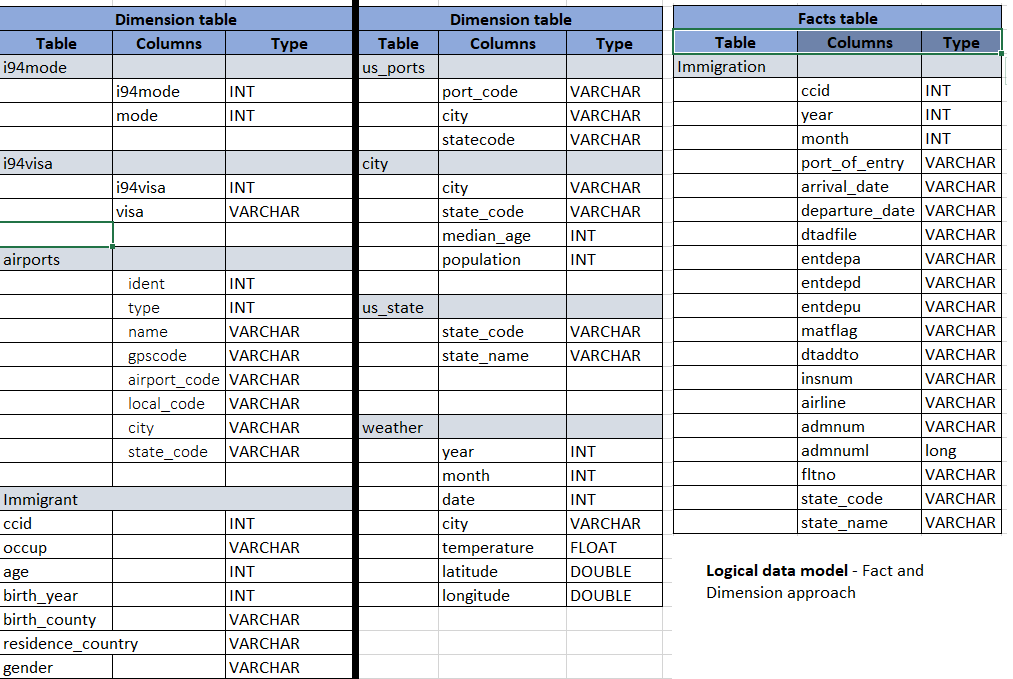
        
        
        
#### Dictionary Data
    Dictionary data is provided by Udacity 
    a)	i94cntyl.txt: Country and the corresponding codes. 
    b)	i94addrl.txt:  USA state name and code. We need to cleanup unwanted "'".
    c)	i94model.txt:  i94Mode. 
    d)	i94prtl.txt:  USA port codes map to city, state. 
    e)	i94visa.txt: Visa types.



#### Programming language
    a)This project will use Python, PySpark, SQL for programing.
    b)Other utility and tools
        Jupyter notebook – for initial data assessment and analysis 


### Step 4: Run Pipelines to Model the Data 

#### Airflow DAGs will be used to Orchestrate end to end pipeline
At high level we will use below Operators to build end to end flow.

    a) Airflow Operator to Create EMR cluster
    b) Airflow Operator EMR cluster status/sensor check
    c) Airflow Operator EMR cluster terminate
    d) Airflow Operator Load and Transfrom data ( Using Spark and S3)
    e) Airflow Operator Data Quality check
  
 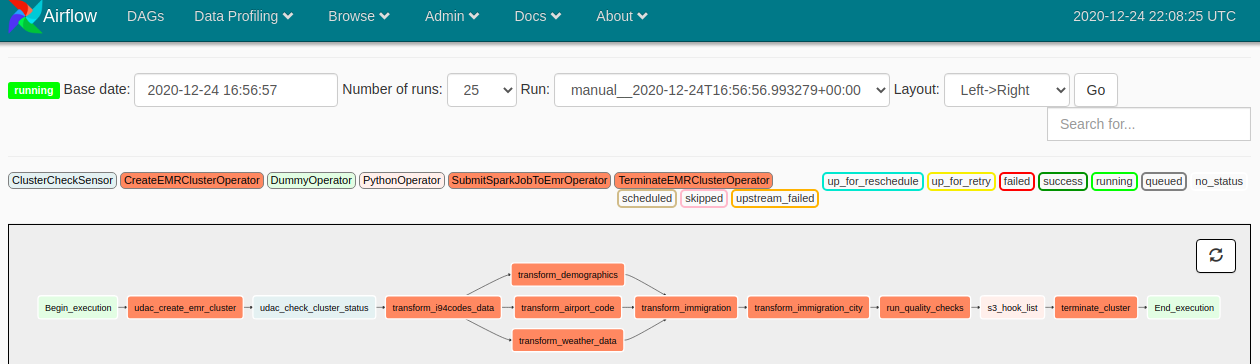

#### 4.2 Data Quality Checks
         
    a)Data Dictionary will used to check relevence of data.
    b)Duplicate data will be removed
    c)Missing data will be ignored
    d)Intrgrity constraint will be maintained by Primary keys

#### 4.3 Data dictionary 
Create a data dictionary for your data model. For each field, provide a brief description of what the data is and where it came from. You can include the data dictionary in the notebook or in a separate file.

Dictionary data is provided by Udacity 

    a)    i94cntyl.txt: Country and the corresponding codes. 
    b)    i94addrl.txt:  USA state name and code. We need to cleanup unwanted "'".
    c)    i94model.txt:  i94Mode. 
    d)    i94prtl.txt:  USA port codes map to city, state. 
    e)    i94visa.txt: Visa types.

#### Step 5: Complete Project Write Up


##### 1) Clearly state the rationale for the choice of tools and technologies for the project.

    This project will use EC2, S3, EMR cluster (Spark), Apache Airflow - will be core components of solution design.
    a)    S3 – S3 Storage is elastic and scales up/shrinks down effectivly as per demand. S3 sotrage is distributed and b=ehnce good choice for Spark work load processing. Hence it is a very good choice of Big Data workloads.
    
    b)    EMR – Spark EMR cluster can scale up/shrink-down as per workload demand. Spark is best at parallel/distributed computing. Hence it is a very good choice of Big Data workloads.
    
    c)    Apache Airflow – Data pipeline and orchestration. Airflow can manages end to end orchestration of workflow as well as monitor status of each task/job. Airflow has many useful Hooks and Operator already built in for connecting and managing Cloud services. Hence it is a very good choice of Big Data workloads.
 

##### 2) Propose how often the data should be updated and why.

As per current usecase requirement, data can be update once a day. However, if usecase needs change, data load frequency can be configured to hourly.

##### 3) Write a description of how you would approach the problem differently under the following scenarios:


##### 3.1) The data was increased by 100x.

    a) In case data volume increase by 100%, we need to scale Up EMR Spark cluster and S3 capacity. Since Spark is distributed in nature and can increase parallel/distributed computing based on number of worker nodes, increasing EMR capacity (worker nodes) should help to accomodate 100x increase.
    
    c) Also, S3 storage can easily scale up to compliment Spark processing and provide distributed storage for 100x data increase.

    d)Airflow only orchestrates flow/pipeline and does not process data, Airflow capacity increase is not required.


##### 3.2) The data populates a dashboard that must be updated on a daily basis by 7am every day.
    For Such requirement, we can extend our Data lake by Adding RedShift OLAP tables. Spark can populate RedShift OLAP cubes with transformed data in advance. This will help to manage SLA for "Data being ready by 7 AM every day" for consumption. 


##### 3.3) The database needed to be accessed by 100+ people.
    For concurrent data consumption by Applications/Consumer, it will be good idea to Add RedShift OLAP tables (Staging and OLAP). This will ensure data-consumtion by Applications/Consumer is rendered by RedShift. RedShift is distributed and MPP database, which can scale up to petabyte data and is good solution-block in Big Data landscape.